# Initialize data

In [209]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import librosa

bearingA = pd.read_excel("lozyska polaczone.xlsx",sheet_name='Łożysko_A').iloc[:,0:6].set_index('Time [s]')
bearingF = pd.read_excel("lozyska polaczone.xlsx",sheet_name='Łożysko_F').iloc[:,0:6].set_index('Time [s]')
bearingA, bearingF

(              A_P1       A_P2      A_P3      A_P4      A_P5
 Time [s]                                                   
 0.20004  -0.519396  -0.857482 -3.493313 -4.067562 -4.106657
 0.20016   2.180017  -2.306301 -4.304790 -4.888874 -7.063714
 0.20028   3.852659  -6.568164 -1.653053  2.848104 -8.963711
 0.20040  -1.038305  -9.880408 -3.249150  3.476073 -5.875597
 0.20052   1.854455  -6.060931 -6.129766 -2.603546 -1.718865
 ...            ...        ...       ...       ...       ...
 7.84668   5.163884  -3.730574 -3.578094  1.375764 -2.592770
 7.84680   5.414033  -0.391876 -5.562483  3.157149 -0.717225
 7.84692   2.640328 -11.806190 -4.744551  6.137130 -4.663985
 7.84704   3.450035 -13.799896 -1.833365  3.692787 -6.056617
 7.84716   4.667976  -3.848692  0.140911  0.377114 -4.198191
 
 [63727 rows x 5 columns],
                 F_P1        F_P2        F_P3        F_P4        F_P5
 Time [s]                                                            
 0.20004    16.960818   41.203741  -48

In [210]:
bearingA_to_npArray = bearingA.to_numpy()
bearingA_to_npArray[:,1]

array([ -0.857482,  -2.306301,  -6.568164, ..., -11.80619 , -13.799896,
        -3.848692])

# Function creating features

Ekstrakcja cech jest kluczowym etapem w analizie dźwięku. Używamy biblioteki librosa do wydobycia różnych cech z nagrania dźwiękowego. W tym przypadku, ekstrahujemy następujące cechy:

**MFCCs (Mel-frequency cepstral coefficients)**: Są to współczynniki reprezentujące krótkoczasowe moc spektralną, które są szeroko stosowane w rozpoznawaniu mowy i analizie dźwięku. Dają one dobrą reprezentację kształtu spektralnego dźwięku.

**Chroma STFT (Short-time Fourier Transform)**: Odnosi się do całkowitej energii w każdym z dwunastu różnych pasmach chromatycznych, co daje informację o tonalności dźwięku.

**Spectral Contrast**: Opisuje różnicę amplitud między pikami a dolinami w spektrum dźwięku, co może wskazywać na różnorodność brzmień w nagraniu.

**Zero Crossing Rate**: Jest to częstotliwość, z jaką sygnał przechodzi przez zero. Jest to prosty wskaźnik charakterystyki dźwięku, który może być użyteczny w różnicowaniu dźwięków o różnej teksturze.

In [211]:
def features_creator(segment, sample_rate, condition):
    nyquist_freq = sample_rate / 2
    fmin = nyquist_freq / 8  
    n_bands = 2  
    spectral_contrast = librosa.feature.spectral_contrast(y=segment, sr=sample_rate, fmin=fmin, n_bands=n_bands)
    mfccs = librosa.feature.mfcc(y=segment, sr=sample_rate, n_mfcc=13)
    chroma_stft = librosa.feature.chroma_stft(y=segment, sr=sample_rate)
    zero_crossing_rate = librosa.feature.zero_crossing_rate(y=segment)
    features = {        
        'condition': condition,
        'mfccs': np.mean(mfccs, axis=1),
        'chroma': np.mean(chroma_stft, axis=1),
        'spectral_contrast': np.mean(spectral_contrast, axis=1),
        'zero_crossing_rate': np.mean(zero_crossing_rate)}
    return features


In [212]:
def data_spliter_with_feature(db, sample_rate, segment_length, num_segment, condition):
    all_features = []
    i=0
    for column in range(db.shape[1]):
        for iter_seg in range(num_segment):
            start = int(iter_seg * sample_rate * segment_length)
            end = start + int(sample_rate * segment_length)
            segment = db[start:end,column]
            
            if len(segment) == int(sample_rate * segment_length):
                features = features_creator(segment, sample_rate, condition)
            all_features.append(features)
            i += 1
    return pd.DataFrame(all_features)

In [213]:
sample_rate = 8335 
segment_length = 1  
num_segment = 10
bratingA_feature = data_spliter_with_feature(bearingA.to_numpy(),sample_rate, segment_length, num_segment, 'good')
bratingF_feature = data_spliter_with_feature(bearingF.to_numpy(),sample_rate, segment_length, num_segment, 'bad')
segmented_df_features = pd.concat([bratingA_feature, bratingF_feature]).reset_index()
print(segmented_df_features)

    index condition                                              mfccs  \
0       0      good  [360.9440262004734, 20.003691317767895, 3.9610...   
1       1      good  [362.30239923332556, 20.431091766572138, 2.508...   
2       2      good  [362.2666453814209, 21.218643073828694, 4.2341...   
3       3      good  [361.6348117463978, 20.032295228344836, 5.0661...   
4       4      good  [361.4205100435612, 22.863667045193406, 5.5137...   
..    ...       ...                                                ...   
95     45       bad  [600.0517272545254, -59.994896255559574, -41.7...   
96     46       bad  [597.9383221414788, -61.38347116796358, -42.34...   
97     47       bad  [597.9383221414788, -61.38347116796358, -42.34...   
98     48       bad  [597.9383221414788, -61.38347116796358, -42.34...   
99     49       bad  [597.9383221414788, -61.38347116796358, -42.34...   

                                               chroma  \
0   [0.8213298885713286, 0.6100090413791207, 0.392... 

In [214]:
def expand_feature_column(series):
    feature_df = pd.DataFrame(series.tolist())
    return feature_df
new_columns = [segmented_df_features['condition']]
for column in segmented_df_features.columns:
    if column != 'condition':
        expanded_feature = expand_feature_column(segmented_df_features[column])
        expanded_feature.columns = [f"{column}_{i}" for i in range(expanded_feature.shape[1])]
        
        new_columns.append(expanded_feature)

numeric_df_features = pd.concat(new_columns, axis=1).drop('index_0', axis=1)
numeric_df_features.columns

Index(['condition', 'mfccs_0', 'mfccs_1', 'mfccs_2', 'mfccs_3', 'mfccs_4',
       'mfccs_5', 'mfccs_6', 'mfccs_7', 'mfccs_8', 'mfccs_9', 'mfccs_10',
       'mfccs_11', 'mfccs_12', 'chroma_0', 'chroma_1', 'chroma_2', 'chroma_3',
       'chroma_4', 'chroma_5', 'chroma_6', 'chroma_7', 'chroma_8', 'chroma_9',
       'chroma_10', 'chroma_11', 'spectral_contrast_0', 'spectral_contrast_1',
       'spectral_contrast_2', 'zero_crossing_rate_0'],
      dtype='object')

C:\Users\Admin\AppData\Local\Temp\ipykernel_11520\1951660688.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_df['condition'] = numeric_df_features['condition']


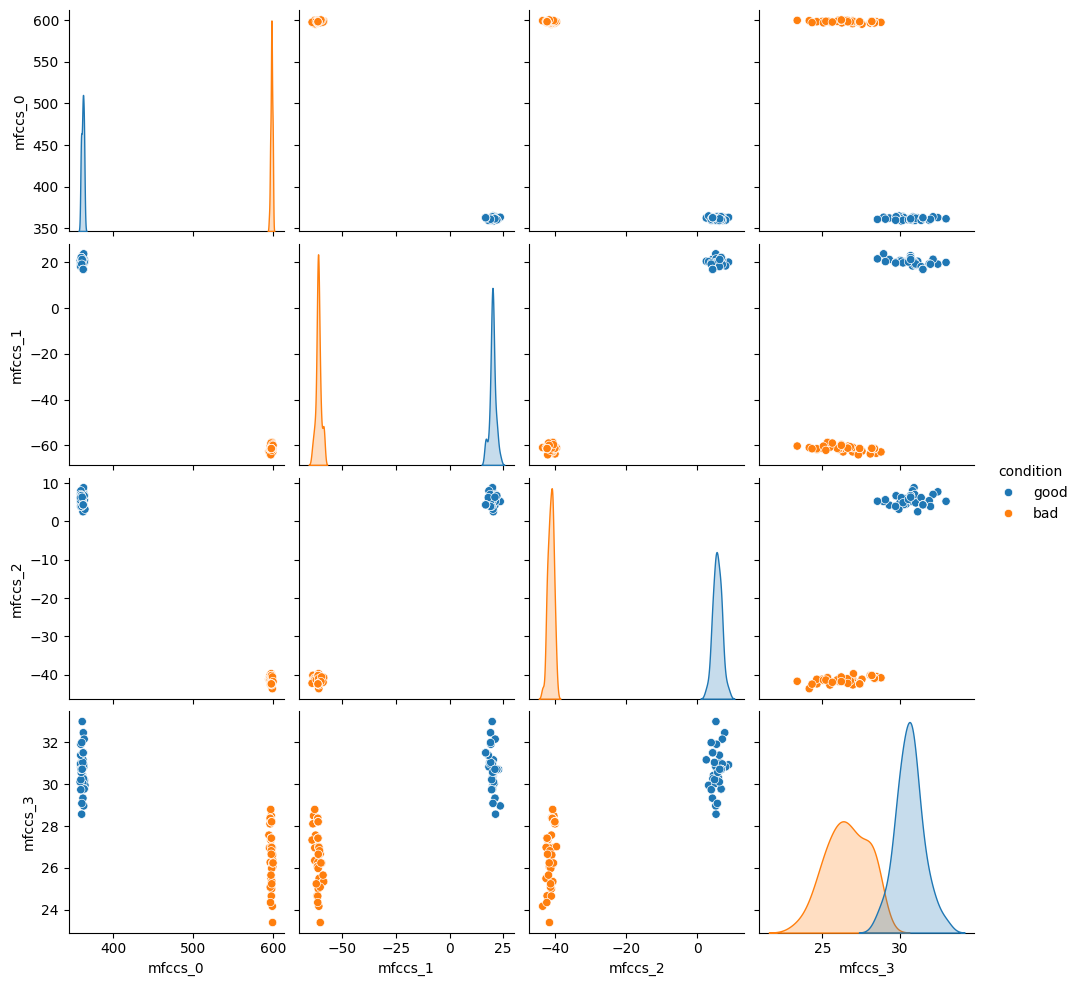

In [216]:
import seaborn as sns

# Wybór podzbioru cech do wizualizacji
selected_columns = numeric_df_features.columns[1:5]  # Przykładowy wybór pierwszych 10 kolumn cech
selected_df = numeric_df_features[selected_columns]
selected_df['condition'] = numeric_df_features['condition']

# Wyświetlenie sns.pairplot
sns.pairplot(selected_df, hue='condition')
plt.show()